## Note if we want ot use RESNET replace VGG16 with RESNET 

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,Activation,GlobalMaxPooling2D,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from glob import glob
import os
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X_train='E:/naturalimages/Plant/Train'
X_test='E:/naturalimages/Plant/Test'

In [3]:
# re-size all the images to this  VGG16 works on 224,224 size
IMAGE_SIZE = [224, 224]

In [4]:
# add preprocessing layer to the front of VGG
# include_top=False means last layer is getting removed 
## this code is alreadu given in Keras 
## weights='imagenet' for reuseing the weights

## vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
## vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
## rest = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
## inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

rest = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
# don't train existing weights
for layer in rest.layers:         ## for layer in rest.layers // for layer in inception.layers // for layer in vgg.layers
    layer.trainable = False     ## IF we keep true then model will train again and again 

In [6]:
# useful for getting number of classes
folders=glob('E:/naturalimages/Plant/Train/*') ## * have to be included this will decide no of folders
folders

['E:/naturalimages/Plant/Train\\Parasite',
 'E:/naturalimages/Plant/Train\\Uninfected']

In [7]:
# our layers - you can add more if you want // dense(512) // activation='relu'
x = Flatten()(rest.output)       ## x = Flatten()(rest.output) // x = Flatten()(inception.output) //x = Flatten()(vgg.output)

# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x) ## we have 2 features normal and phenoma /instead of 2 we can provide (len(folders))
## x = Dropout(0.5)(prediction)

In [8]:
prediction

<tf.Tensor 'dense/Identity:0' shape=(None, 2) dtype=float32>

In [9]:
# create a model object
model = Model(inputs=rest.input, outputs=prediction)  

## model = Model(inputs=vgg.input, outputs=prediction) 
## model = Model(inputs=rest.input, outputs=prediction)
## model = Model(inputs=inception.input, outputs=prediction)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
# tell the model what cost and optimization method to use
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('E:/naturalimages/Plant/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('E:/naturalimages/Plant/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 416 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [13]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,                                          ## epochs=5/10/50
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set))

Epoch 1/5
13/13 [==============================] - 754s 58s/step - loss: 1.6017 - accuracy: 0.8341 - val_loss: 5.2048 - val_accuracy: 0.6791
Epoch 2/5
13/13 [==============================] - 564s 43s/step - loss: 0.7085 - accuracy: 0.9279 - val_loss: 4.3689 - val_accuracy: 0.6791
Epoch 3/5
13/13 [==============================] - 573s 44s/step - loss: 0.6634 - accuracy: 0.9471 - val_loss: 4.4926 - val_accuracy: 0.6791
Epoch 4/5
13/13 [==============================] - 680s 52s/step - loss: 0.9802 - accuracy: 0.9279 - val_loss: 1.0420 - val_accuracy: 0.3284
Epoch 5/5
13/13 [==============================] - 591s 45s/step - loss: 0.4793 - accuracy: 0.9615 - val_loss: 1.5820 - val_accuracy: 0.6791


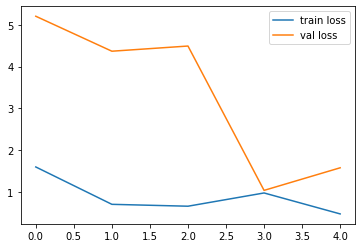

<Figure size 432x288 with 0 Axes>

In [32]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

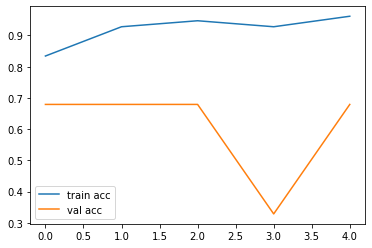

<Figure size 432x288 with 0 Axes>

In [15]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [16]:
model.save('cat_dog_classifier11986.h5')

## Predictions

In [17]:
y_pred = model.predict(test_set)
y_pred

array([[0.99720323, 0.00279676],
       [0.9858214 , 0.0141786 ],
       [0.99385864, 0.00614144],
       [0.98990846, 0.01009158],
       [0.9939214 , 0.00607861],
       [0.98875076, 0.01124925],
       [0.998083  , 0.00191698],
       [0.99446326, 0.0055367 ],
       [0.98769855, 0.01230139],
       [0.9851656 , 0.01483439],
       [0.9933304 , 0.00666954],
       [0.9948973 , 0.00510266],
       [0.99574476, 0.00425521],
       [0.9947941 , 0.00520595],
       [0.9952766 , 0.00472341],
       [0.9955076 , 0.00449241],
       [0.997209  , 0.00279099],
       [0.98811114, 0.01188887],
       [0.9912213 , 0.00877864],
       [0.9927912 , 0.00720881],
       [0.99001884, 0.00998116],
       [0.990284  , 0.00971597],
       [0.9870525 , 0.01294751],
       [0.98929137, 0.01070867],
       [0.98990893, 0.01009103],
       [0.99002105, 0.00997895],
       [0.9925565 , 0.00744351],
       [0.9899977 , 0.01000225],
       [0.99164224, 0.00835781],
       [0.98479766, 0.01520228],
       [0.

In [18]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [20]:
model=load_model('cat_dog_classifier11986.h5')

In [21]:
from tensorflow.keras.preprocessing import image


In [22]:
img=image.load_img('E:/naturalimages/Plant/Test/Parasite/C39P4thinF_original_IMG_20150622_105554_cell_22.png',target_size=(224,224))

In [23]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [24]:
x.shape

(224, 224, 3)

In [25]:
x=x/255

In [26]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [27]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [28]:
model.predict(img_data)

array([[9.9999857e-01, 1.4235211e-06]], dtype=float32)

In [29]:
a=np.argmax(model.predict(img_data), axis=1)

In [30]:
a==1

array([False])

In [31]:
if(a==1):
    print("unParasite")
else:
    print("parasite")

parasite
